# MIS780 Advanced AI For Business - Assignment 2 - T2 2024

## Task Number: Business Problem Name

**Student Name:** _enter your full name here_

**Student ID:** _enter your student ID here_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

*Use this section to introduce the business problem, data set, method, experiments, and obtained results*

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Carry out necessary data preprocessing and exploration.*

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(2024)
np.random.seed(2024)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_task3 = pd.read_csv('/Part3_GoldPrice.csv', index_col='Date', parse_dates=["Date"], dayfirst=True)

print(data_task3.head())
print(data_task3.describe())

               USD     EUR     GBP      INR      AED     CNY
Date                                                        
1985-01-07  298.25  392.55  261.17  3741.23  1091.58  835.80
1985-01-08  302.00  395.32  263.07  3820.70  1114.06  853.01
1985-01-09  300.50  393.54  263.14  3742.23  1097.47  840.31
1985-01-10  303.80  397.63  268.02  3853.39  1126.83  862.79
1985-01-11  304.25  398.60  270.57  3845.57  1135.85  869.69
                USD           EUR           GBP            INR           AED  \
count  10110.000000  10110.000000  10110.000000   10110.000000  10110.000000   
mean     799.748447    670.104859    541.061313   43943.953027   2937.273903   
std      544.877305    463.238285    418.207087   43584.544951   2001.450645   
min      252.800000    222.200000    156.890000    3687.170000    928.480000   
25%      356.712500    307.275000    221.530000   11751.397500   1311.205000   
50%      440.625000    374.990000    265.350000   18312.495000   1618.690000   
75%     1270.

In [5]:
data_task3.info()

data_task3.dtypes

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10110 entries, 1985-01-07 to 2023-10-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     10110 non-null  float64
 1   EUR     10110 non-null  float64
 2   GBP     10110 non-null  float64
 3   INR     10110 non-null  float64
 4   AED     10110 non-null  float64
 5   CNY     10110 non-null  float64
dtypes: float64(6)
memory usage: 552.9 KB


,0
USD,float64
EUR,float64
GBP,float64
INR,float64
AED,float64
CNY,float64


In [6]:
data_task3.isnull().sum()

,0
USD,0
EUR,0
GBP,0
INR,0
AED,0
CNY,0


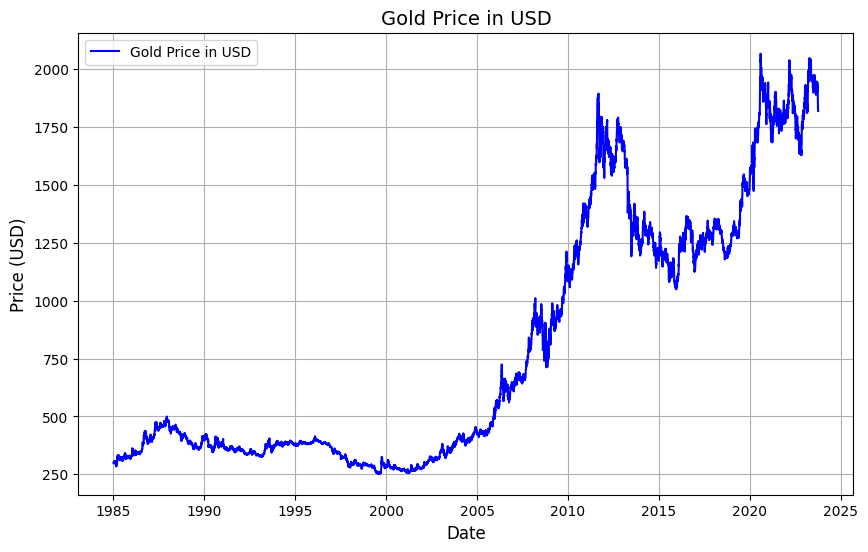

In [12]:
# Plot gold prices across different currencies from data_task3

fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better aspect ratio
ax.plot(data_task3['USD'], color='blue', label='Gold Price in USD')

# Set plot title and labels
ax.set_title('Gold Price in USD', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)

# Enable grid and show legend
ax.grid(True)
ax.legend(loc='upper left')

# Display the plot
plt.show()


In [14]:
# Function to split data_task3 into training and testing sets based on the specified time range
def train_test_split(data, start_year, end_year):
    # Training data: from time_start to time_end
    train_data = data.loc[f"{start_year}":f"{end_year}", "USD"]
    # Test data: from the year after time_end onwards
    test_data = data.loc[f"{end_year+1}":, "USD"]
    return train_data, test_data

# Define the start and end years for the split
time_start = 1985
time_end = 2021

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data_task3, time_start, time_end)


In [15]:
print('Training set shape:', train_data.shape)
print('Test set shape:', test_data.shape)

Training set shape: (9650,)
Test set shape: (460,)


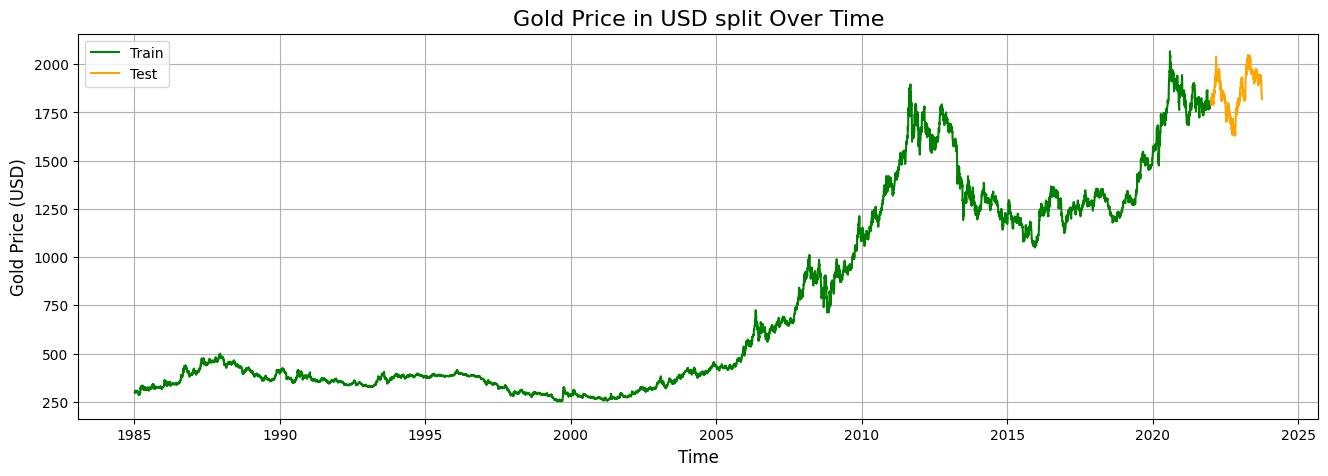

In [16]:
# Plot the training and testing sets with custom colors
plt.figure(figsize=(16, 5))
plt.plot(train_data, label='Train', color='green')  # Set the training data color to green
plt.plot(test_data, label='Test', color='orange')   # Set the testing data color to orange

# Add title and labels
plt.title('Gold Price in USD split Over Time', fontsize=16)
plt.ylabel('Gold Price (USD)', fontsize=12)
plt.xlabel('Time', fontsize=12)

# Display legend and show plot
plt.legend(loc='upper left')
plt.grid(True)  # Add grid for better readability
plt.show()


In [17]:
# Scale the training data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the scaler
train_data_reshaped = train_data.values.reshape(-1, 1)  # Reshape the data to a 2D array
train_data_scaled = scaler.fit_transform(train_data_reshaped)  # Fit and transform the data

# Display the shape of the scaled training set
print(f'Training set scaled shape: {train_data_scaled.shape}')


Training set scaled shape: (9650, 1)


In [19]:
def create_sequence(sequence, n_steps, forecasting_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix + forecasting_horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
step_num = 50  # Number of time steps
forecast_horizon = 14  # 2-week forecasting horizon

# Create sequences from the scaled training data
train_task3_x, train_task3_y = create_sequence(train_data_scaled, step_num, forecast_horizon)

# Reshape train_task3_y to add an extra dimension
train_task3_y = train_task3_y.reshape(train_task3_y.shape[0], train_task3_y.shape[1], 1)

# Display the shapes of the training data
print(f'Shape of train_task3_x: {train_task3_x.shape}')
print(f'Shape of train_task3_y: {train_task3_y.shape}')

Shape of train_task3_x: (9587, 50, 1)
Shape of train_task3_y: (9587, 14, 1)


In [24]:
print('train_task3_x shape:', train_task3_x.shape)
print('train_task3_y shape:', train_task3_y.shape)

train_task3_x shape: (9587, 50, 1)
train_task3_y shape: (9587, 14, 1)


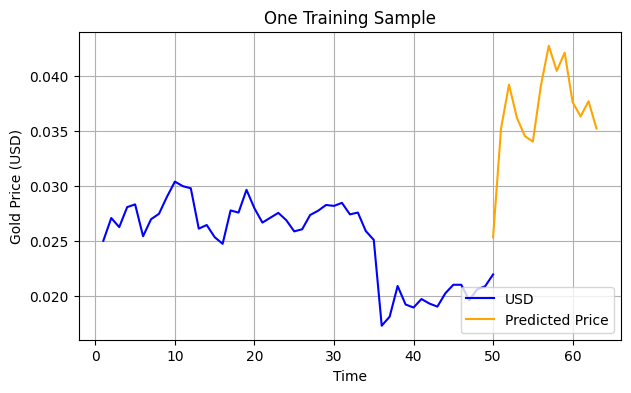

In [26]:
# Plot a single training sample to visualize input sequence and predicted output
plt.figure(figsize=(7, 4))

# Plot the input sequence (USD) over the time steps
plt.plot(np.arange(1, step_num + 1), train_task3_x[0, :, 0], label='USD', color='blue')

# Plot the predicted prices for the forecasting horizon
plt.plot(np.arange(step_num, step_num + forecast_horizon), train_task3_y[0], label='Predicted Price', color='orange')

# Set the title and axis labels
plt.title('One Training Sample')
plt.ylabel('Gold Price (USD)')
plt.xlabel('Time')

# Display the legend and plot
plt.legend(loc='lower right')
plt.grid(True)  # Add a grid for better readability
plt.show()


<a id = "cell_model"></a>
## 3. Predictive Modeling

*Create and explain your models (e.g., model architecture, model parameters). Evaluate the models on the experimental data sets.*

In [27]:
# Build the LSTM model for time series forecasting
model_lstm = Sequential()

# Add LSTM layer with 200 units and 'tanh' activation function
model_lstm.add(LSTM(200, activation='tanh', input_shape=(step_num, 1)))

# Add a Dense output layer to predict the 2-week forecast
model_lstm.add(Dense(forecast_horizon))

# Compile the model using RMSprop optimizer and mean squared error loss
model_lstm.compile(optimizer='RMSprop', loss='mse')

# Display the model architecture
model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200)                 │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │           2,814 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,414 (642.24 KB)

 Trainable params: 164,414 (642.24 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
model_lstm.fit(train_task3_x, train_task3_y, epochs=150, batch_size=64)

Epoch 1/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 0.0225
Epoch 2/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - loss: 0.0018
Epoch 3/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - loss: 8.4746e-04
Epoch 4/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - loss: 6.5517e-04
Epoch 5/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 5.3289e-04
Epoch 6/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 4.5469e-04
Epoch 7/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - loss: 4.0753e-04
Epoch 8/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - loss: 3.8231e-04
Epoch 9/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - loss: 3.5579e-04
Epoch 10/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - loss: 3.4887e-04
Epoch 11/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 3.3704e-04
Epoch 12/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 3.2624e-04
Epoch 13/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 3.1710e-04
Epoch 14/150
150/150 ━━━━━━━━

In [30]:
# Rescale the test data using the same scaler (sc) as the training data
test_inputs_task3 = test_data.values.reshape(-1, 1)  # Reshape test data to 2D array
test_inputs_task3_scaled = scaler.transform(test_inputs_task3)  # Apply the scaling transformation

# Create sequences from the scaled test data
X_task3_test, y_task3_test = create_sequence(test_inputs_task3_scaled, step_num, forecast_horizon)

# Display the shape of the task3 test set sequences
print(f'Shape of X_task3_test: {X_task3_test.shape}')
print(f'Shape of y_task3_test: {y_task3_test.shape}')


Shape of X_task3_test: (397, 50, 1)
Shape of y_task3_test: (397, 14, 1)


In [31]:
# Predict gold prices using the LSTM model
predicted_gold_price_task3 = model_lstm.predict(X_task3_test)

# Inverse transform the predicted values and the test labels to original scale
predicted_gold_price_task3 = scaler.inverse_transform(predicted_gold_price_task3)
y_task3_test = scaler.inverse_transform(y_task3_test.reshape(-1, 1)).reshape(y_task3_test.shape)

# Print the shape of the predicted gold prices
print(f'Predicted gold price shape: {predicted_gold_price_task3.shape}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Predicted gold price shape: (397, 14)


In [32]:
# Define a function to calculate and display the Mean Absolute Error (MAE)
def return_mae(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    print(f"Mean Absolute Error: {mae:.2f}")

# Loop through each day in the forecasting horizon to calculate MAE for each forecast
for i in range(forecast_horizon):
    print(f"Forecasting Horizon {i+1} day(s):")
    return_mae(y_task3_test[:, i], predicted_gold_price_task3[:, i])

Forecasting Horizon 1 day(s):
Mean Absolute Error: 13.35
Forecasting Horizon 2 day(s):
Mean Absolute Error: 17.30
Forecasting Horizon 3 day(s):
Mean Absolute Error: 20.13
Forecasting Horizon 4 day(s):
Mean Absolute Error: 23.21
Forecasting Horizon 5 day(s):
Mean Absolute Error: 26.13
Forecasting Horizon 6 day(s):
Mean Absolute Error: 28.96
Forecasting Horizon 7 day(s):
Mean Absolute Error: 31.99
Forecasting Horizon 8 day(s):
Mean Absolute Error: 34.51
Forecasting Horizon 9 day(s):
Mean Absolute Error: 36.68
Forecasting Horizon 10 day(s):
Mean Absolute Error: 39.60
Forecasting Horizon 11 day(s):
Mean Absolute Error: 41.60
Forecasting Horizon 12 day(s):
Mean Absolute Error: 44.20
Forecasting Horizon 13 day(s):
Mean Absolute Error: 45.66
Forecasting Horizon 14 day(s):
Mean Absolute Error: 47.33


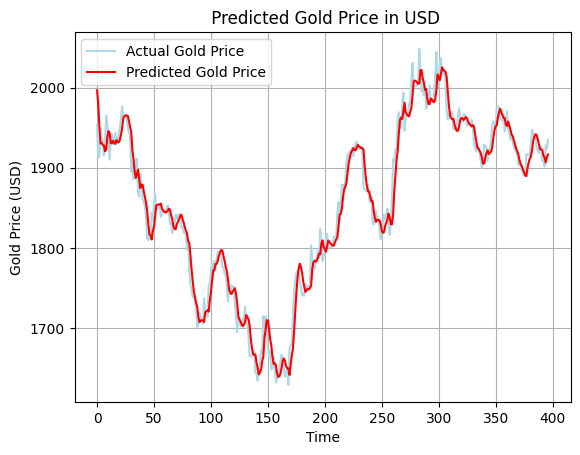

In [37]:
def predictions_plot_task3(actual, predicted):
    # Plot the real vs predicted gold prices
    plt.plot(actual, color="lightblue", label="Actual Gold Price")
    plt.plot(predicted, color="red", label="Predicted Gold Price")

    # Add title and labels
    plt.title(" Predicted Gold Price in USD")
    plt.xlabel("Time")
    plt.ylabel("Gold Price (USD)")

    # Display legend and show the plot
    plt.legend()
    plt.grid(True)  # Add grid for better readability
    plt.show()

# Plot predictions for the first day in the forecasting horizon
predictions_plot_task3(y_task3_test[:, 0], predicted_gold_price_task3[:, 0])


<a id = "cell_report"></a>
## 4. Experiments Report

*Provide a summary of experimental results, explain the meaning of your result
and how your model can be used to address the related business problem.*